# Outliers and Label Encoding

1. **[Identify and Deal with Outliers](#example1)**
1. **[Label Encoding](#example2)**

<a id=example1> </a>
# Identify and Deal with Outliers

## Example National Oceanic and Atmospheric Association

### Objective

We will be examining lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) from 1987 through 2020. Because this would be many millions of rows to read into the notebook, we've preprocessed the data so it contains just the year and the number of strikes.

We will examine the range of total lightning strike counts for each year and identify outliers. Then we will plot the yearly totals on a scatterplot.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
# Read in data
df = pd.read_csv('datasets/eda_outliers_dataset1.csv')

print(df.shape)

# Print first 10 rows
df.head(10)

(34, 2)


,year,number_of_strikes
0,2020,15620068
1,2019,209166
2,2018,44600989
3,2017,35095195
4,2016,41582229
5,2015,37894191
6,2014,34919173
7,2013,27600898
8,2012,28807552
9,2011,31392058


Next, let's convert the number of strikes value to a more readable format on the graph (e.g., converting 100,000 to 100K, 3,000,000 to 3M, and so on).

In [5]:
def readable_numbers(x):
    """takes a large number and formats it into K,M to make it more readable"""
    if x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s

# Use the readable_numbers() function to create a new column 
df['number_of_strikes_readable']=df['number_of_strikes'].apply(readable_numbers)

In [8]:
print(df.head(10))

print("Mean:" + readable_numbers(np.mean(df['number_of_strikes'])))
print("Median:" + readable_numbers(np.median(df['number_of_strikes'])))

   year  number_of_strikes number_of_strikes_readable
0  2020           15620068                      15.6M
1  2019             209166                       209K
2  2018           44600989                      44.6M
3  2017           35095195                      35.1M
4  2016           41582229                      41.6M
5  2015           37894191                      37.9M
6  2014           34919173                      34.9M
7  2013           27600898                      27.6M
8  2012           28807552                      28.8M
9  2011           31392058                      31.4M
Mean:26.8M
Median:28.3M


A boxplot can help to visually break down the data into percentiles / quartiles, which are important summary statistics. The shaded center of the box represents the middle 50th percentile of the data points. This is the interquartile range, or IQR. 

The boxplot "whiskers" extend 1.5x the IQR by default.

/var/folders/1h/3xv2s5v153548qm156_k0h400000gn/T/ipykernel_13687/408997470.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))


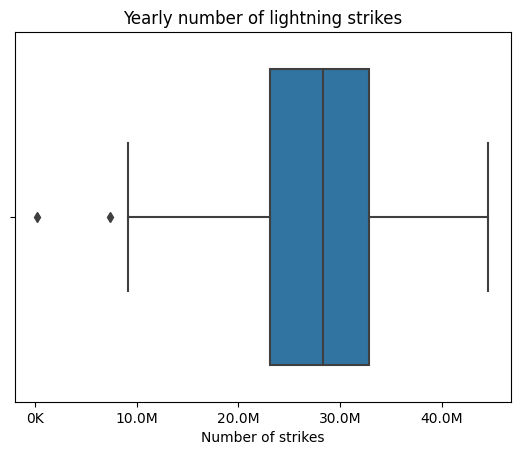

In [9]:
# Create boxplot
box = sns.boxplot(x=df['number_of_strikes'])
g = plt.gca()
box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))
plt.xlabel('Number of strikes')
plt.title('Yearly number of lightning strikes');

The points to the left of the left whisker are outliers. Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers.

One important point for every data professional: do not assume an outlier is erroneous unless there is an explanation or reason to do so.

Let's define our IQR, upper, and lower limit.

In [10]:
# Calculate 25th percentile of annual strikes
percentile25 = df['number_of_strikes'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = df['number_of_strikes'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print('Lower limit is: '+ readable_numbers(lower_limit))

Lower limit is: 8.6M


Now we can use a Boolean mask to select only the rows of the dataframe where the number of strikes is less than the lower limit we calculated above. These rows are the outliers on the low end.

In [11]:
# Isolate outliers on low end
df[df['number_of_strikes'] < lower_limit]

,year,number_of_strikes,number_of_strikes_readable
1,2019,209166,209K
33,1987,7378836,7.4M


Let's get a visual of all of the data points with the outlier values colored red.

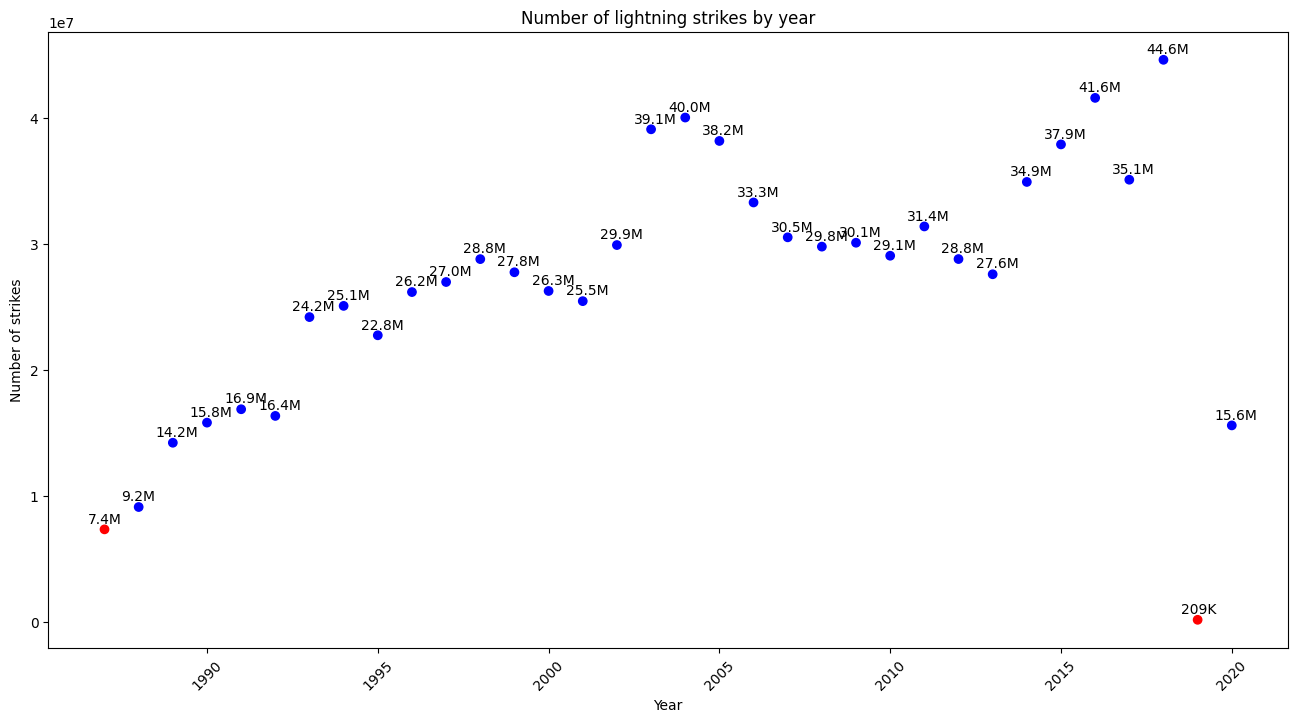

In [12]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i]-0.5, y[i]+500000, s=readable_numbers(y[i]))

colors = np.where(df['number_of_strikes'] < lower_limit, 'r', 'b')

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['year'], df['number_of_strikes'],c=colors)
ax.set_xlabel('Year')
ax.set_ylabel('Number of strikes')
ax.set_title('Number of lightning strikes by year')
addlabels(df['year'], df['number_of_strikes'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

### Investigating the outliers 2019 and 1987

Let's examine the two outlier years a bit more closely. In the section above, we used a preprocessed dataset that didn't include a lot of the information that we're accustomed to having in this data. In order to further investigate the outlier years, we'll need more information, so we're going to import data from these years specifically.

In [13]:
df_2019 = pd.read_csv('datasets/eda_outliers_dataset2.csv')
df_2019.head()

,date,number_of_strikes,center_point_geom
0,2019-12-01,1,POINT(-79.7 35.3)
1,2019-12-01,1,POINT(-84.7 39.3)
2,2019-12-01,1,POINT(-83.4 38.9)
3,2019-12-01,1,POINT(-71.5 35.2)
4,2019-12-01,1,POINT(-87.8 41.6)


First, we'll convert the `date` column to datetime. This will enable us to extract two new columns: `month` and `month_txt`. Then, we'll sort the data by `month` and `month_txt`, sum it, and sort the values. 

In [15]:
# Convert `date` column to datetime
df_2019['date']= pd.to_datetime(df_2019['date'])

# Create 2 new columns
df_2019['month'] = df_2019['date'].dt.month
df_2019['month_txt'] = df_2019['date'].dt.month_name().str.slice(stop=3)

# Group by `month` and `month_txt`, sum it, and sort. Assign result to new df
df_2019_by_month = df_2019.groupby(['month','month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12).reset_index()
df_2019_by_month

,month,month_txt,number_of_strikes
0,12,Dec,209166


2019 appears to have data only for the month of December. The likelihood of there not being any lightning from January to November 2019 is ~0. This appears to be a case of missing data. We should probably exclude 2019 from the analysis (for most use cases).

#### Import data for 1987

Now let's inspect the data from the other outlier year, 1987.


In [16]:
# Read in 1987 data
df_1987 = pd.read_csv('datasets/eda_outliers_dataset3.csv')

In [17]:
# Convert `date` column to datetime
df_1987['date'] = pd.to_datetime(df_1987['date'])

# Create 2 new columns
df_1987['month'] = df_1987['date'].dt.month
df_1987['month_txt'] = df_1987['date'].dt.month_name().str.slice(stop=3)

# Group by `month` and `month_txt`, sum it, and sort. Assign result to new df
df_1987_by_month = df_1987.groupby(['month','month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12).reset_index()
df_1987_by_month

,month,month_txt,number_of_strikes
0,1,Jan,23044
1,2,Feb,61020
2,3,Mar,117877
3,4,Apr,157890
4,5,May,700910
5,6,Jun,1064166
6,7,Jul,2077619
7,8,Aug,2001899
8,9,Sep,869833
9,10,Oct,105627


1987 has data for every month of the year. Hence, this outlier should be treated differently than 2019, which is missing data. 

Finally, let's re-run the mean and median after removing the outliers. Our final takeaway from our lesson on outliers is that outliers significantly affect the dataset's mean, but do not significantly affect the median. 

To remove the outliers, we'll use a Boolean mask to create a new dataframe that contains only the rows in the original dataframe where the number of strikes >= the lower limit we calculated above.

In [18]:
# Create new df that removes outliers
df_without_outliers = df[df['number_of_strikes'] >= lower_limit]

# Recalculate mean and median values on data without outliers
print("Mean:" + readable_numbers(np.mean(df_without_outliers['number_of_strikes'])))
print("Median:" + readable_numbers(np.median(df_without_outliers['number_of_strikes'])))

Mean:28.2M
Median:28.8M


**When we exclude those outliers, the mean and median are much closer together, suggesting a fairly evenly distributed dataset.**

Both the mean and the median changed, but the mean much more so. It is clear that outlier values can affect the distributions of the data and the conclusions that can be drawn from them.

<a id=example2> </a>
# Label Encoding



### Objective

We will be examining monthly lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) for 2016&ndash;2018. The dataset includes three columns:  

|date|number_of_strikes|center_point_geom|
|---|---|---|  

The objective is to assign the monthly number of strikes to the following categories: mild, scattered, heavy, or severe. Then we will create a heatmap of the three years so we can get a high-level understanding of monthly lightning severity from a simple diagram.   

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# File needs to be downloaded from here -> 


# Read in the data
df = pd.read_csv('datasets/eda_label_encoding_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479003 entries, 0 to 10479002
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   date               object
 1   number_of_strikes  int64 
 2   center_point_geom  object
dtypes: int64(1), object(2)
memory usage: 239.8+ MB


### Create a categorical variable `strike_level`

Begin by converting the `date` column to datetime. Then we'll create a new `month` column that contains the first three letters of each month.  

In [4]:
# Convert `date` column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create new `month` column
df['month'] = df['date'].dt.month_name().str.slice(stop=3)

df.head()

,date,number_of_strikes,center_point_geom,month
0,2016-08-05,16,POINT(-101.5 24.7),Aug
1,2016-08-05,16,POINT(-85 34.3),Aug
2,2016-08-05,16,POINT(-89 41.4),Aug
3,2016-08-05,16,POINT(-89.8 30.7),Aug
4,2016-08-05,16,POINT(-86.2 37.9),Aug


Next, we'll encode the months as categorical information. This allows us to specifically designate them as categories that adhere to a specific order, which is helpful when we plot them later. We'll also create a new `year` column. Then we'll group the data by year and month, sum the remaining columns, and assign the results to a new dataframe.

In [5]:
# Create categorical designations
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Encode `month` column as categoricals 
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

# Create `year` column by extracting the year info from the datetime object
df['year'] = df['date'].dt.strftime('%Y')

# Create a new df of month, year, total strikes
df_by_month = df.groupby(['year', 'month']).sum(numeric_only=True).reset_index()
df_by_month.head()

# NOTE: In pandas v.2.X+ you must set 'numeric_only=True' or else the sum() function will throw an error

,year,month,number_of_strikes
0,2016,Jan,313595
1,2016,Feb,312676
2,2016,Mar,2057527
3,2016,Apr,2636427
4,2016,May,5800500


Now we'll create a new column called `strike_level` that contains a categorical variable representing the lightning strikes for each month as mild, scattered, heavy, or severe. The `pd.qcut` pandas function makes this easy. We just input the column to be categorized, the number of quantiles to sort the data into, and how we want to name each quantile. For more information on this function, refer to the [pandas qcut() documentation](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html).

In [6]:
# Create a new column that categorizes number_of_strikes into 1 of 4 categories
df_by_month['strike_level'] = pd.qcut(
    df_by_month['number_of_strikes'],
    4,
    labels = ['Mild', 'Scattered', 'Heavy', 'Severe'])
df_by_month.head()

,year,month,number_of_strikes,strike_level
0,2016,Jan,313595,Mild
1,2016,Feb,312676,Mild
2,2016,Mar,2057527,Scattered
3,2016,Apr,2636427,Heavy
4,2016,May,5800500,Severe


### Encode `strike_level` into numerical values

Now that we have a categorical `strike_level` column, we can extract a numerical code from it using `.cat.codes` and assign this number to a new column. 

In [7]:
# Create new column representing numerical value of strike level
df_by_month['strike_level_code'] = df_by_month['strike_level'].cat.codes
df_by_month.head()

,year,month,number_of_strikes,strike_level,strike_level_code
0,2016,Jan,313595,Mild,0
1,2016,Feb,312676,Mild,0
2,2016,Mar,2057527,Scattered,1
3,2016,Apr,2636427,Heavy,2
4,2016,May,5800500,Severe,3


We can also create binary "dummy" variables from the `strike_level` column. This is a useful tool if we'd like to pass the categorical variable into a model. To do this, we could use the function `pd.get_dummies()`. Note that this is just to demonstrate the functionality of `pd.get_dummies()`. Simply calling the function as we do below will not convert the data unless we reassigned the result back to a dataframe. 

`pd.get_dummies(df['column'])` 🠚 **df unchanged**  
`df = pd.get_dummies(df['column'])` 🠚 **df changed**

We don't need to create dummy variables for our heatmap, so let's continue without converting the dataframe.

In [8]:
pd.get_dummies(df_by_month['strike_level'])

,Mild,Scattered,Heavy,Severe
0,True,False,False,False
1,True,False,False,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,True
5,False,False,False,True
6,False,False,False,True
7,False,False,False,True
8,False,False,True,False
9,False,True,False,False


### Create a heatmap of number of strikes per month

We want our heatmap to have the months on the x-axis and the years on the y-axis, and the color gradient should represent the severity (mild, scattered, heavy, severe) of lightning for each month. A simple way of preparing the data for the heatmap is to pivot it so the rows are years, columns are months, and the values are the numeric code of the lightning severity. 

We can do this with the `df.pivot()` method. It accepts arguments for `index`, `columns`, and `values`, which we'll specify as described. For more information on the `df.pivot()` method, refer to the [pandas pivot() method documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html).

In [9]:
# Create new df that pivots the data
df_by_month_plot = df_by_month.pivot(index='year', columns='month', values='strike_level_code')
df_by_month_plot.head()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2016,0,0,1,2,3,3,3,3,2,1,0,0
2017,1,0,1,2,2,2,3,3,2,1,0,0
2018,1,2,1,1,2,3,3,3,2,1,0,0


At last we can plot the heatmap! We'll use seaborn's `heatmap()` function for this.

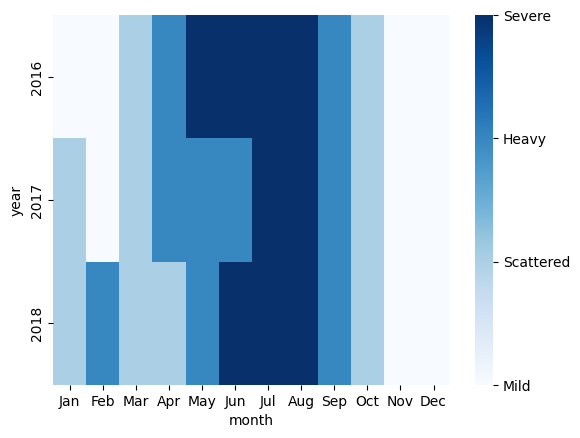

In [10]:
ax = sns.heatmap(df_by_month_plot, cmap = 'Blues')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2, 3])
colorbar.set_ticklabels(['Mild', 'Scattered', 'Heavy', 'Severe'])
plt.show()

The heatmap indicates that for all three years, the most lightning strikes occurred during the summer months. A heatmap is an easily digestable way to understand a lot of data in a single graphic. 